
# Install and Import Dependencies


In [99]:
!pip install opencv-python matplotlib imageio gdown 

In [100]:
!pip install tensorflow==2.10.1

In [101]:
!pip install opencv-python

In [102]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio # to convert numpy array to gif

# Building Data Loading Functions

In [103]:
import gdown #To get data straight away from gogole drive

In [104]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame) #for less pre-processing data
        frames.append(frame[190:236,80:220,:])#static slicing function to isolate the mouth region in the videos
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std #standerdize or scale our particular image feature by using mean and std

In [105]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "] #Every character we might expect in the video

In [106]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [107]:
#To convert char to num and vice versa
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [108]:
char_to_num(['r','a','v','i']) #converts char to integers

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([18,  1, 22,  9])>

In [109]:
num_to_char([18,  1,  22, 9]) #converts int to resp char

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'r', b'a', b'v', b'i'], dtype=object)>

**We use these functions to convert and reconvert our text to encodings**

In [110]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': #To ignore silence
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [111]:
def load_data(path:str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames,alignments

In [112]:
test_path = '.data/s1/bbal6n.mpg'

In [113]:
#The function load_data does the exact split
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [114]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

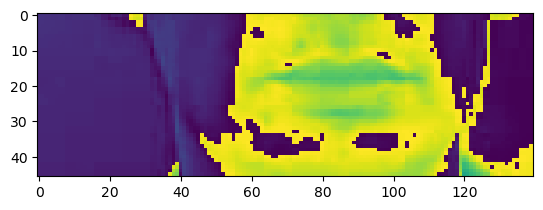

In [115]:
#lets look at a frame
plt.imshow(frames[0])

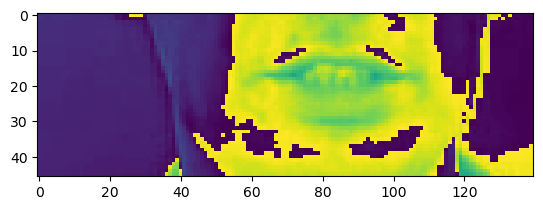

In [116]:
plt.imshow(frames[37])

In [117]:
alignments #word rep of what is being said

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [118]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


In [119]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [120]:
#wrapping inside a mappable function
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Create Data Pipeline

In [121]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [122]:
len(test)

50

In [123]:
frames, alignments = data.as_numpy_iterator().next()

In [124]:
frames

array([[[[[ 1.4830974 ],
          [ 1.4469243 ],
          [ 1.5192705 ],
          ...,
          [ 0.32555798],
          [ 0.36173108],
          [ 0.36173108]],

         [[ 1.5916167 ],
          [ 1.3745781 ],
          [ 1.5192705 ],
          ...,
          [ 0.32555798],
          [ 0.36173108],
          [ 0.36173108]],

         [[ 1.4469243 ],
          [ 1.4469243 ],
          [ 1.4469243 ],
          ...,
          [ 0.28938487],
          [ 0.28938487],
          [ 0.28938487]],

         ...,

         [[ 1.0490202 ],
          [ 1.0490202 ],
          [ 1.0490202 ],
          ...,
          [ 0.03617311],
          [ 0.03617311],
          [ 0.        ]],

         [[ 1.0128471 ],
          [ 1.0128471 ],
          [ 1.0128471 ],
          ...,
          [ 0.        ],
          [ 9.224143  ],
          [ 9.224143  ]],

         [[ 1.0128471 ],
          [ 1.0128471 ],
          [ 1.0128471 ],
          ...,
          [ 9.224143  ],
          [ 9.224143  ],
          

In [125]:
len(frames)

2

In [126]:
test = data.as_numpy_iterator()

In [127]:
val = test.next(); val[0]

array([[[[[1.5577686 ],
          [1.5215415 ],
          [1.4853142 ],
          ...,
          [0.36227176],
          [0.36227176],
          [0.36227176]],

         [[1.6302229 ],
          [1.4128599 ],
          [1.4853142 ],
          ...,
          [0.36227176],
          [0.36227176],
          [0.36227176]],

         [[1.4853142 ],
          [1.4853142 ],
          [1.5215415 ],
          ...,
          [0.39849895],
          [0.3260446 ],
          [0.3260446 ]],

         ...,

         [[1.0868154 ],
          [1.0505881 ],
          [1.0505881 ],
          ...,
          [0.14490871],
          [0.14490871],
          [0.14490871]],

         [[1.0505881 ],
          [1.0505881 ],
          [1.0505881 ],
          ...,
          [0.10868153],
          [0.10868153],
          [0.10868153]],

         [[1.0505881 ],
          [1.0505881 ],
          [1.0505881 ],
          ...,
          [0.10868153],
          [0.10868153],
          [0.10868153]]],


        [[[1.4490

In [128]:
#converting array to gif
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.237930297851562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.237930297851562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.237930297851562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.237930297851562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.237930297851562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.237930297851562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.237930297851562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

Lossy conversion from float32 to uint8. Range [0.0, 9.237930297851562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.237930297851562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.237930297851562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.237930297851562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.237930297851562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.237930297851562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.237930297851562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

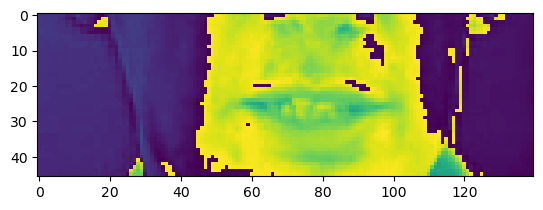

In [129]:
# 0:videos, 0: 1st video out of the batch,  0: return the 1st frame in the video 
plt.imshow(val[0][0][35])

In [130]:
#annotation for the video we selected
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set white with p five again'>

# Designing the Deep Neural Network

In [131]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [132]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [133]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [134]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_6 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_7 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [135]:
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [136]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'????????????????????????????????????????????????????????????????????????ss6'>

In [137]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'????????????????????????????????????????????????????????????????????????ss6'>

In [138]:
model.input_shape

(None, 75, 46, 140, 1)

In [139]:
model.output_shape

(None, 75, 41)

# Setup Training Options and Train

In [140]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [141]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [142]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [143]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [144]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [145]:
schedule_callback = LearningRateScheduler(scheduler)

In [146]:
example_callback = ProduceExample(data)

In [147]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
  5/450 [..............................] - ETA: 4:03:15 - loss: 172.1925

KeyboardInterrupt: 

**since fitting the model requires a GPU for faster epochs, we take the model checkpoint created to make it easier**

# Make Predictions

In [148]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /home/tvrraviteja/Documents/LipNet/checkpoints.zip
100%|██████████████████████████████████████| 94.5M/94.5M [00:27<00:00, 3.45MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [149]:
model.load_weights('models/checkpoint')

In [151]:
test_data = data.as_numpy_iterator()

In [153]:
test_data.next()

(array([[[[[ 1.1169125 ],
           [ 1.1169125 ],
           [ 0.67812544],
           ...,
           [ 0.31911787],
           [ 0.27922812],
           [ 0.27922812]],
 
          [[ 1.0371331 ],
           [ 1.1568023 ],
           [ 0.63823575],
           ...,
           [ 0.31911787],
           [ 0.27922812],
           [ 0.27922812]],
 
          [[ 1.5556996 ],
           [ 1.4360304 ],
           [ 1.0770228 ],
           ...,
           [ 0.19944867],
           [ 0.19944867],
           [ 0.15955894]],
 
          ...,
 
          [[ 0.99724334],
           [ 0.99724334],
           [ 0.99724334],
           ...,
           [ 0.        ],
           [ 0.        ],
           [ 0.        ]],
 
          [[ 0.99724334],
           [ 0.99724334],
           [ 0.99724334],
           ...,
           [ 0.        ],
           [ 0.        ],
           [ 0.        ]],
 
          [[ 0.99724334],
           [ 0.99724334],
           [ 0.99724334],
           ...,
           [ 0

In [152]:
sample = test_data.next()

In [154]:
yhat = model.predict(sample[0])

1/1 [==============================] - 4s 4s/step


In [155]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green at u zero please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by y four please'>]

In [156]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [157]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green at u zero please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by y four please'>]

# Test on a Video

In [174]:
sample = load_data(tf.convert_to_tensor('./data/s1/pgwz1a.mpg'))

In [175]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green with z one again'>]

In [176]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [177]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [178]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green with z one again'>]